# Lab 6 - Data Splitting in Prediction
STAT 450 \
TA: Gian Carlo (GC) \
Feb 14, 2025

In [1]:
# Preamble ###
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(readr))
suppressPackageStartupMessages(library(vip))
suppressPackageStartupMessages(library(tidymodels))
suppressPackageStartupMessages(library(readr))

ggplot2::theme_set(theme_light())
ggplot2::theme_update(text = element_text(size=25))
options(repr.plot.width=15, repr.plot.height=7.5)

## Background

- Last Wednesday, 
you learned in class why you should split your data into training and test data sets 
to avoid double dipping when doing model selection for inference.
- Today, we're going to see how this applies in a prediction setting.
- In prediction, you want to maximize the prediction accuracy (appropriately measured) of your model.
- If you use your whole sample to fit the model *and* estimate the prediction accuracy,
you are going to (possibly severely) underestimate the out-of-sample prediction accuracy.
    - This is because the model is fit to maximize the (in-sample) prediction accuracy,
so you need to test your model on new data to estimate the out-of-sample prediction accuracy.
- You can achieve this by splitting your data as before,
fitting your model on the training data and then
estimating the out-of-sample prediction accuracy using the test data.
- But what happens if you also want to do model selection?

**Setting:** 
- You want to develop a model for prediction.
- You currently have three competing models and want to choose the best one
according to some measure of prediction accuracy.
- You split your data into a training set and a test set and consider the following two approaches:

**Approach 1:**
1. We use the *training* set to fit the models.
2. We select the model with the best prediction accuracy in the *training* set.
3. We test the model in the *test* set to obtain an estimate of the out-of-sample error of the selected model.

<p style="color: red;">What do you think of this approach? </p>

**Approach 2**

1. We use the *training* set to fit the models.
2. We select the model with the best prediction accuracy in the *test* set.
3. We use these results to obtain an estimate of the out-of-sample prediction accuracy of the selected model.

<p style="color: red;">What do you think of this approach? </p>

### Solution: validation set

- One way to address this shortcoming is to further split your data.
- Specifically, the *validation set* is a second split of the training data.
- Thus we end up with three data sets: (1) training set; (2) validation set; and (3) test set.

1. We use the training set to fit as many models as we want.
2. We select the model with the best prediction accuracy in the *validation* set (in-sample prediction accuracy).
3. Once we decide which model is the best, we estimate the out-of-sample prediction accuracy using the *test* set.

*Note:* This is not the only approach.
E.g., you can also do $K$-fold cross-validation, 
where you resample your training data to create $K$ *folds*.
For each fold and each model, 
you leave a part of the fold data out and use it as a validation set.

- Benefits: for each model, you get multiple in-sample prediction measurements (uncertainty quantification!).
- Cons: you have to fit every model $K$ times, which can be costly.

## Today: using the validation set approach with `tidymodels`

![](https://www.tidymodels.org/start/case-study/img/hotel.jpg)\

We're going to be working with a data set from 
[Antonio, de Almeida, and Nunez (2019)](https://www.sciencedirect.com/science/article/pii/S2352340918315191?via%3Dihub).
The data contain information about hotel bookings, 
such as which hotel the guests stay at, the type of room,
the average daily rate, and whether the booking had any children.
Check out the data dictionary 
[here](https://github.com/rfordatascience/tidytuesday/tree/main/data/2020/2020-02-11#data-dictionary).


**Our goal:** create a model to predict how likely a booking is to contain children
as a function of the other variables.

Let's take a look at the data.

*Note:* I borrowed very liberally (including the image above) from the `tidymodels` 
[predictive modelling case study](https://www.tidymodels.org/start/case-study/).

In [2]:
# Data import #### 
hotels <- read_csv("https://tidymodels.org/start/case-study/hotels.csv") %>%
  dplyr::mutate(across(where(is.character), as.factor)) 

dim(hotels)
glimpse(hotels)

Rows: 50000 Columns: 23
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (11): hotel, children, meal, country, market_segment, distribution_chan...
dbl  (11): lead_time, stays_in_weekend_nights, stays_in_week_nights, adults,...
date  (1): arrival_date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 50000    23

Rows: 50,000
Columns: 23
$ hotel                          <fct> City_Hotel, City_Hotel, Resort_Hotel, R…
$ lead_time                      <dbl> 217, 2, 95, 143, 136, 67, 47, 56, 80, 6…
$ stays_in_weekend_nights        <dbl> 1, 0, 2, 2, 1, 2, 0, 0, 0, 2, 1, 0, 1, …
$ stays_in_week_nights           <dbl> 3, 1, 5, 6, 4, 2, 2, 3, 4, 2, 2, 1, 2, …
$ adults                         <dbl> 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2, …
$ children                       <fct> none, none, none, none, none, none, chi…
$ meal                           <fct> BB, BB, BB, HB, HB, SC, BB, BB, BB, BB,…
$ country                        <fct> DEU, PRT, GBR, ROU, PRT, GBR, ESP, ESP,…
$ market_segment                 <fct> Offline_TA/TO, Direct, Online_TA, Onlin…
$ distribution_channel           <fct> TA/TO, Direct, TA/TO, TA/TO, Direct, TA…
$ is_repeated_guest              <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ previous_cancellations         <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ previous_book

Note that the data are severely unbalanced: most bookings didn't have any children!

In [3]:
hotels %>% 
  count(children) %>% 
  mutate(prop = n/sum(n))

children,n,prop
<fct>,<int>,<dbl>
children,4038,0.08076
none,45962,0.91924


### Creating the splits

Below we create the training, validation, and test splits.
We choose a 0.5, 0.25, 0.25 split.
We use the `strata` option to ensure that the (uneven) split of children/no children
is preserved in the splits.

In [4]:
# Create splits ####
set.seed(450)
splits <- initial_validation_split(hotels, 
                                   strata = children, 
                                   prop = c(0.5, 0.25)) # 50% training, 25% validation, 25% test

hotel_training <- training(splits)
hotel_test  <- testing(splits)
hotel_val <- validation(splits)

In [5]:
# Check splits balances ####
hotel_val  %>% 
  count(children) %>% 
  mutate(prop = n/sum(n))

hotel_training %>% 
  count(children) %>% 
  mutate(prop = n/sum(n))

hotel_test  %>% 
  count(children) %>% 
  mutate(prop = n/sum(n))

children,n,prop
<fct>,<int>,<dbl>
children,948,0.07584
none,11552,0.92416


children,n,prop
<fct>,<int>,<dbl>
children,2043,0.08172
none,22957,0.91828


children,n,prop
<fct>,<int>,<dbl>
children,1047,0.08376
none,11453,0.91624


### Defining the competing models

For this case study,
we are going to consider a logistic regression model.
Let $L(\beta;x,y)$ be the likelihood
(which we covered in detail last week)
for parameters $\beta$, covariates $x$, and response $y$.
Since we have a large number of covariates, 
we want to encourage our model to do some feature selection.
We do this through an L1 penalty, or LASSO.
In case you don't remember, instead of just minimizing the negative log-likelihood,
we add a regularization term:
$$
\mathrm{Cost}_\lambda(\beta) = -\log L(\beta;x,y) + \lambda\sum_p|\beta_p|.
$$

**Our goal** is to decide is what penalty $\lambda$ to use for the regularization term.
We specify that below by setting `penalty = tune()`:

In [6]:
# Define models to decide between ####
lr_mod <- 
  logistic_reg(penalty = tune(), mixture = 1) %>% # We are tuning the penalty, ie, choosing between those models
  set_engine("glmnet")

And then we set a comprehensive grid of potential values for the penalty (in log scale):

In [7]:
# Define competing models ####
lr_reg_grid <- tibble(penalty = 10^seq(-4, -1, length.out = 30))

head(lr_reg_grid)

penalty
<dbl>
0.0001000000
0.0001268961
0.0001610262
0.0002043360
0.0002592944
0.0003290345


Below we create some data wrangling steps.
This could be done using `tidyverse`&mdash;for today we are sticking with `tidymodels`
so that you have some comprehensive code using the latter,
but there are good arguments to stick with the former in practice.

In [8]:
# Data wrangling with recipes ####
holidays <- c("AllSouls", "AshWednesday", "ChristmasEve", "Easter", 
              "ChristmasDay", "GoodFriday", "NewYearsDay", "PalmSunday")

lr_recipe <- 
  recipe(children ~ ., data = hotels) %>%               # Children is the response
  step_date(arrival_date) %>%                           # Arrival date is a date variable
  step_holiday(arrival_date, holidays = holidays) %>%   # Dummy indicator for selected holidays (since they affect hotels)
  step_rm(arrival_date) %>%                             # Remove arrival date (used for holidays only)
  step_dummy(all_nominal_predictors()) %>%              # Creates dummy variables for nominal covariates
  step_zv(all_predictors()) %>%                         # Removes covariates with single value (useless)
  step_normalize(all_predictors())                      # Normalize all covariates


# Create workflow ####
lr_workflow <- 
  workflow() %>% 
  add_model(lr_mod) %>% 
  add_recipe(lr_recipe)

## Measuring prediction accuracy

To measure prediction accuracy,
we are going to be using the area under the 
Receiver Operating Characteristic, or [ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).
This is a bit more comprehensive than simply using a pre-defined estimated probability threshold
to classify new data; instead, it accounts for *all* possible probability thresholds.

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/Roc_curve.svg/1024px-Roc_curve.svg.png" width="700"/>
</div>

(Source: https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/Roc_curve.svg/1024px-Roc_curve.svg.png)

### Tuning

The code below:
- fits each model (specified by the penalty) to the training data
- and estimates the in-sample prediction accuracy using the validation data.

In [9]:
# Tune using validation data ####
lr_res <- 
  lr_workflow %>% 
  tune_grid(validation_set(splits),
            grid = lr_reg_grid,
            control = control_grid(save_pred = TRUE),
            metrics = metric_set(roc_auc))

We can visualize the resulting AUC for each value of the penalty:

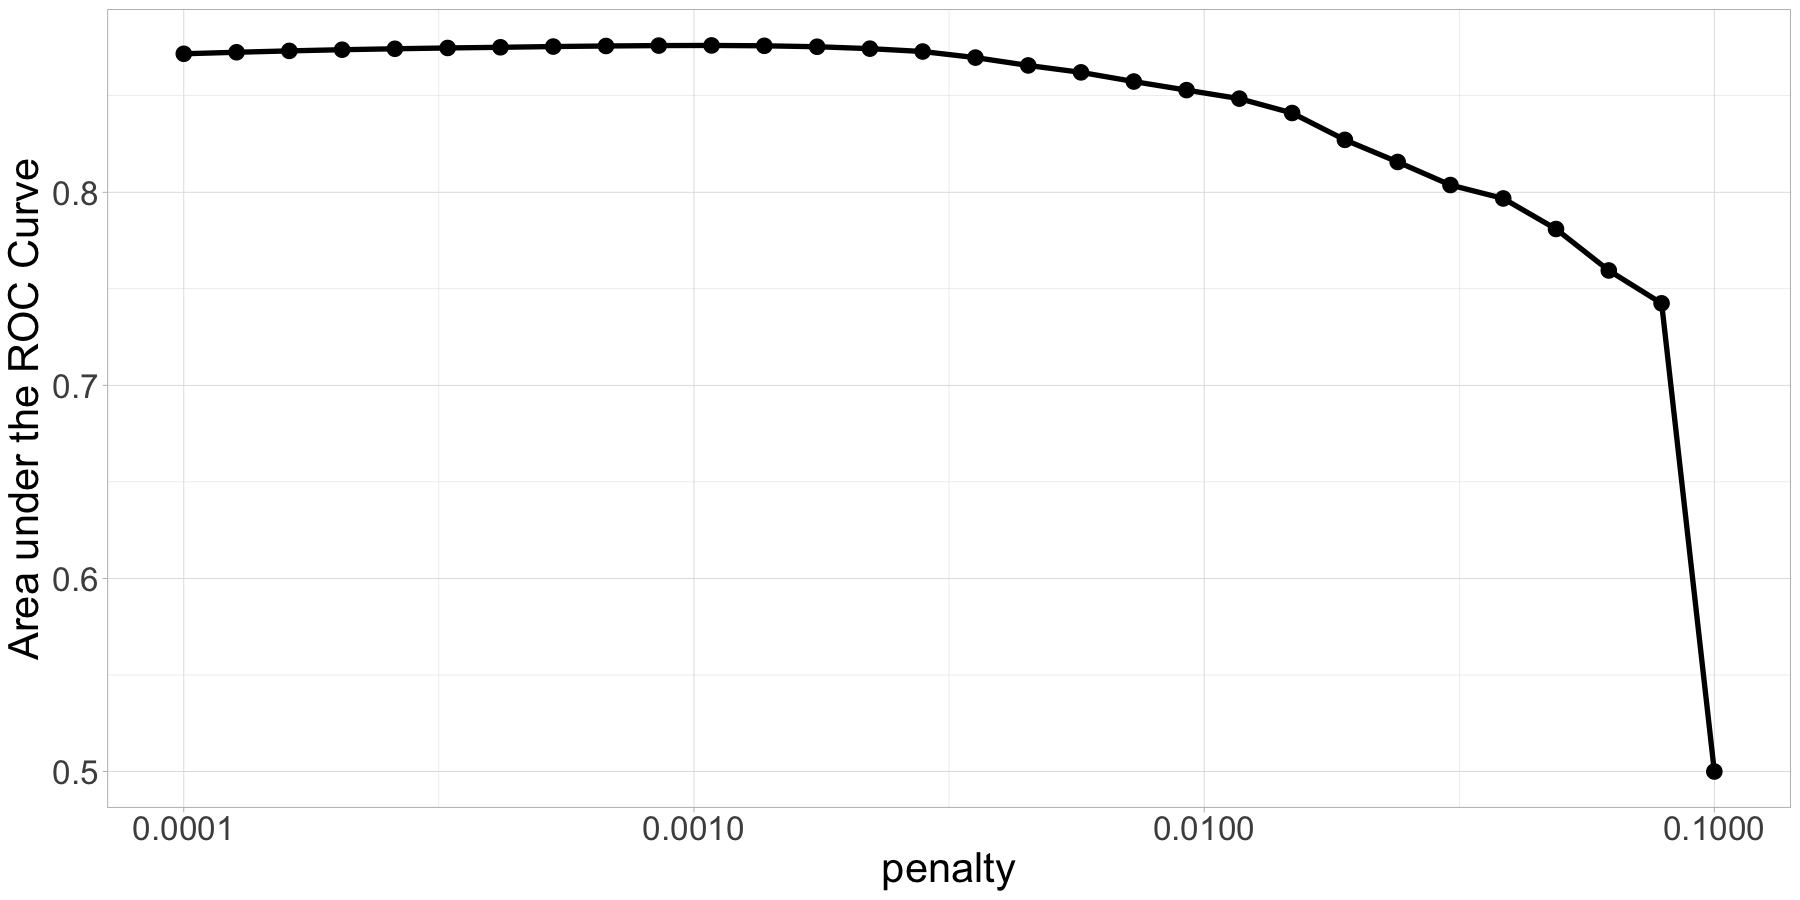

In [10]:
# Visualize tuning ####
lr_plot <- 
  lr_res %>% 
  collect_metrics() %>% 
  ggplot() + 
  geom_point(aes(x = penalty, y = mean), size = 4) + 
  geom_line(aes(x = penalty, y = mean), linewidth = 1.5) + 
  labs(y = "Area under the ROC Curve") +
  scale_x_log10(labels = scales::label_number())

lr_plot 

and print out the top 15 models (by AUC):

In [11]:
# Get best models ####
top_models <-
  lr_res %>% 
  show_best(metric = "roc_auc", n = 15) %>% 
  arrange(desc(mean)) 
top_models

penalty,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
0.0010826367,roc_auc,binary,0.8760524,1,NA,Preprocessor1_Model11
0.0008531679,roc_auc,binary,0.8759763,1,NA,Preprocessor1_Model10
0.0013738238,roc_auc,binary,0.8758664,1,NA,Preprocessor1_Model12
0.0006723358,roc_auc,binary,0.8757653,1,NA,Preprocessor1_Model09
0.0005298317,roc_auc,binary,0.8754763,1,NA,Preprocessor1_Model08
0.0017433288,roc_auc,binary,0.8753782,1,NA,Preprocessor1_Model13
0.0004175319,roc_auc,binary,0.8750912,1,NA,Preprocessor1_Model07
0.0003290345,roc_auc,binary,0.8747461,1,NA,Preprocessor1_Model06
0.0022122163,roc_auc,binary,0.8743897,1,NA,Preprocessor1_Model14


### Choosing the best model

- Model 11 with a penalty of 0.001 and an AUC of ~0.876 is, empirically, the best one.
- However, looking at the plot above, notice that almost all penalties $<0.01$
produce a comparable AUC.
- A larger LASSO penalty will induce more sparsity in the estimated coefficients
when compared with a smaller penalty.
- We want to encourage this behaviour because it will prevent nuisance variables from being included
in the model, which might help prevent overfitting
(and, if we were interested in inference, it would result in a more interpretable model).
- Therefore, we might want to choose a larger penalty, say model 15 with a penalty of $0.002$
(twice the penalty of the best model, and the 13th best one).
- We highlight this penalty with its associated AUC below with a vertical line:

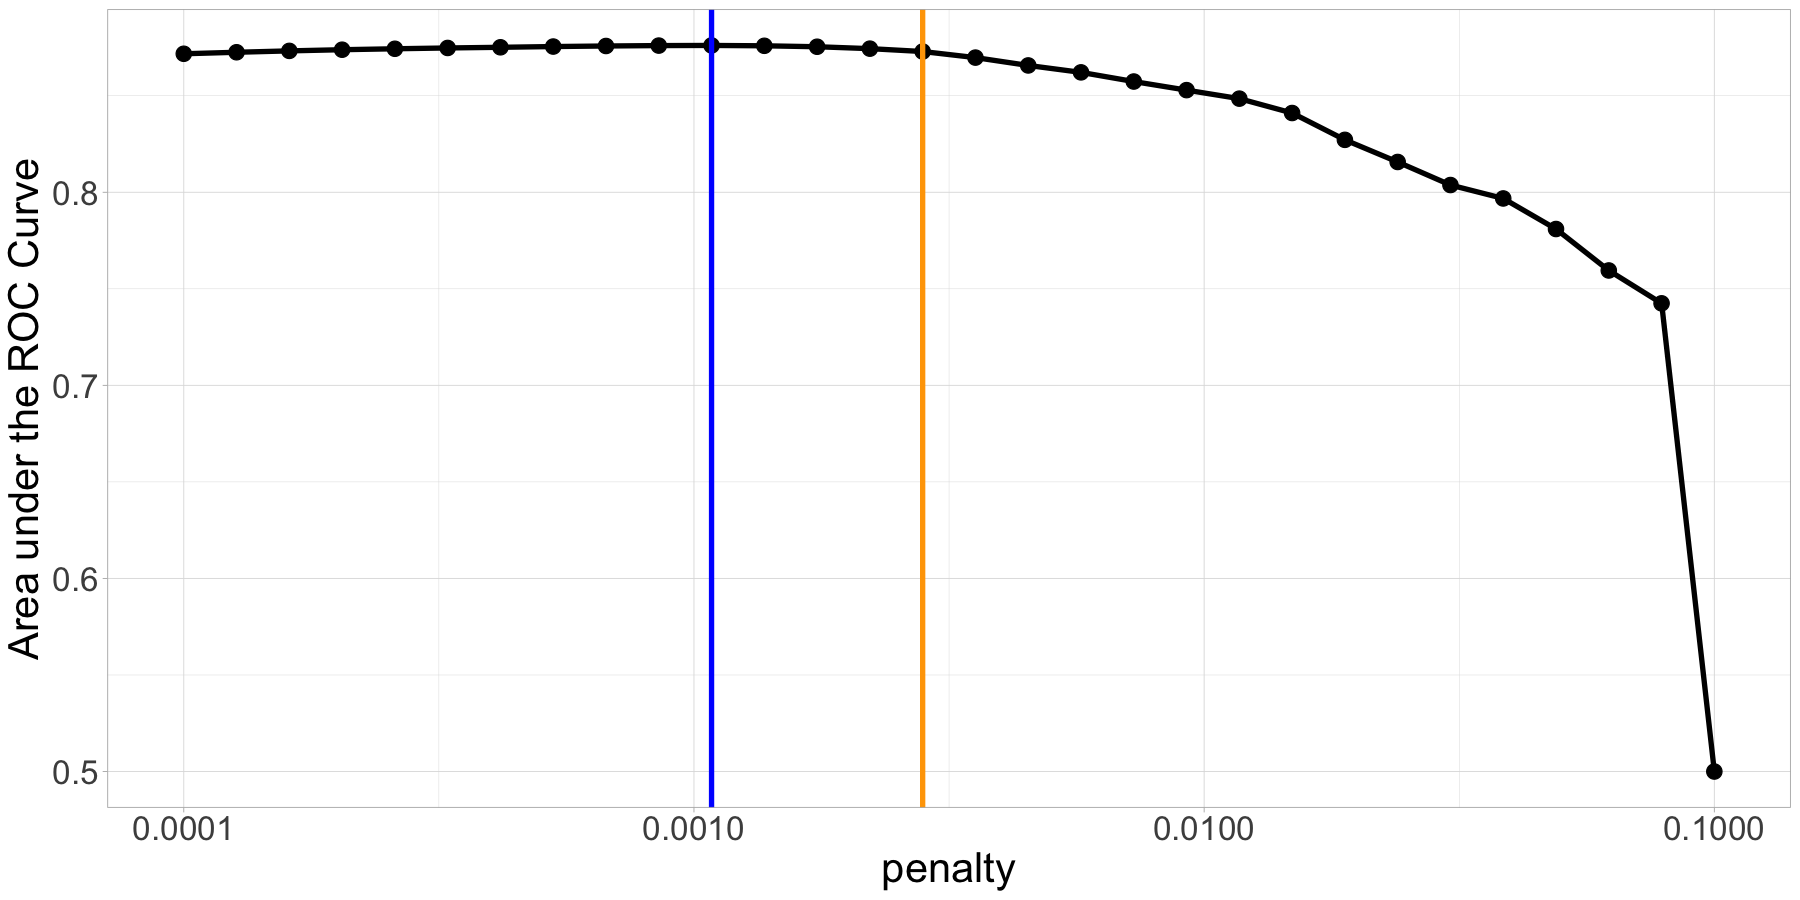

In [19]:
# Visualize again with chosen penalty ####
lr_plot <- 
  lr_res %>% 
  collect_metrics() %>% 
  ggplot() + 
  geom_point(aes(x = penalty, y = mean), size = 4) + 
  geom_line(aes(x = penalty, y = mean), linewidth = 1.5) + 
  geom_vline(xintercept = top_models$penalty[13],
            color = "orange", linewidth = 1.5) +
geom_vline(xintercept = top_models$penalty[1],
            color = "blue", linewidth = 1.5) +
  labs(y = "Area under the ROC Curve") +
  scale_x_log10(labels = scales::label_number())

lr_plot 

### Comparison

To further argue why we would not sacrifice much by choosing the larger penalty,
below we save both penalties and then generate a plot with the entire ROCs plot together.

In [13]:
# Save our chosen best model ####
lr_best <- 
  lr_res %>% 
  collect_metrics() %>% 
  arrange(desc(mean)) %>% 
  slice(13)
lr_best

penalty,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
0.002807216,roc_auc,binary,0.8729004,1,NA,Preprocessor1_Model15


In [14]:
# And save empirical best model ####
lr_best_empirical <- 
  lr_res %>% 
  collect_metrics() %>% 
  arrange(desc(mean)) %>% 
  slice(1)
lr_best_empirical

penalty,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
0.001082637,roc_auc,binary,0.8760524,1,NA,Preprocessor1_Model11


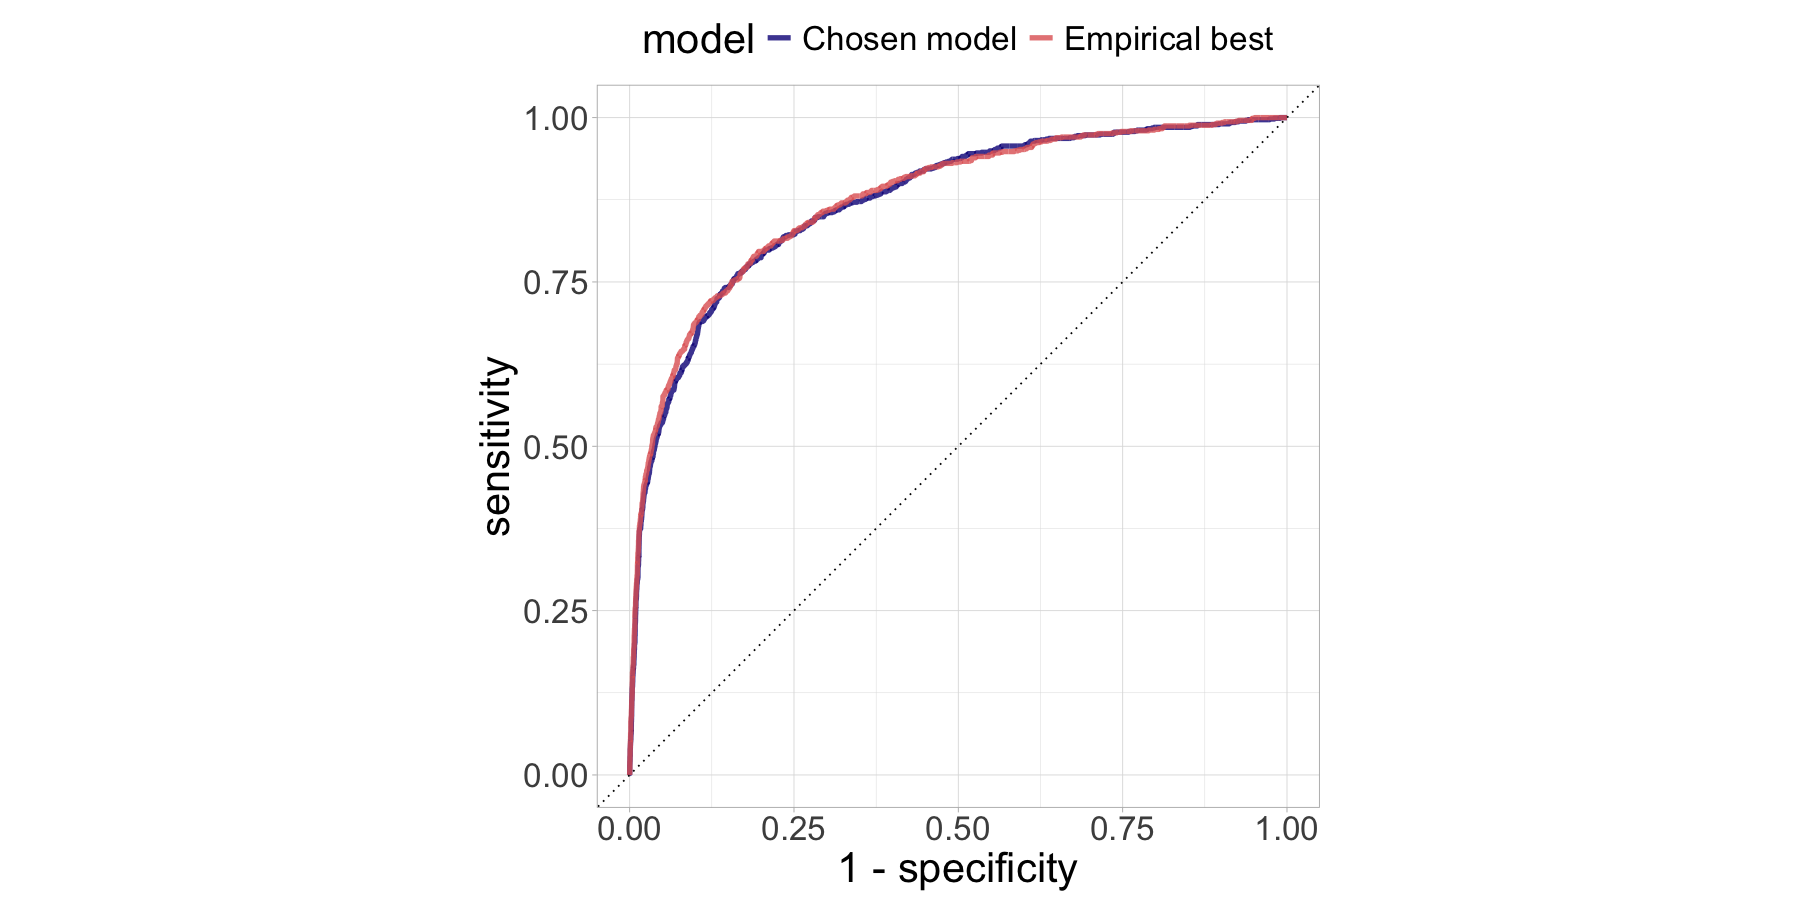

In [15]:
# Plot ROC curve ####
lr_auc_best <- 
  lr_res %>% 
  collect_predictions(parameters = lr_best) %>% 
  roc_curve(children, .pred_children) %>% 
  mutate(model = "Chosen model")

lr_auc_best_empirical <- 
  lr_res %>% 
  collect_predictions(parameters = lr_best_empirical) %>% 
  roc_curve(children, .pred_children) %>% 
  mutate(model = "Empirical best")

bind_rows(lr_auc_best, lr_auc_best_empirical) %>% 
  ggplot(aes(x = 1 - specificity, y = sensitivity, col = model)) + 
  geom_path(lwd = 1.5, alpha = 0.8) +
  geom_abline(lty = 3) + 
  coord_equal() + 
  scale_color_viridis_d(option = "plasma", end = .6)+
  theme(legend.position = "top")


As we can see, both penalties result in nearly identical ROCs.
We thus choose the one with the larger penalty as our best model.

### Estimating the out-of-sample prediction accuracy

- Now we fit the selected model, this (last) time with the test data.
- The resulting AUC is an out-of-sample estimate of the prediction accuracy of our model.
- Ideally, it should be similar to the AUC of the validation data.
Otherwise we should be concerned,
since a much lower out-of-sample AUC could point to potential overfitting.

In [16]:
# Fit model last time ####
last_lr_mod <-
  logistic_reg(penalty = lr_best$penalty, mixture = 1) %>% 
  set_engine("glmnet")

# the last workflow
last_lr_workflow <- 
  lr_workflow %>% 
  update_model(last_lr_mod)

# the last fit
last_lr_fit <- 
  last_lr_workflow %>% 
  last_fit(splits)

last_lr_fit

Warning message:
“`optional` is kept for consistency with the underlying class but TRUE values will be ignored.”
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



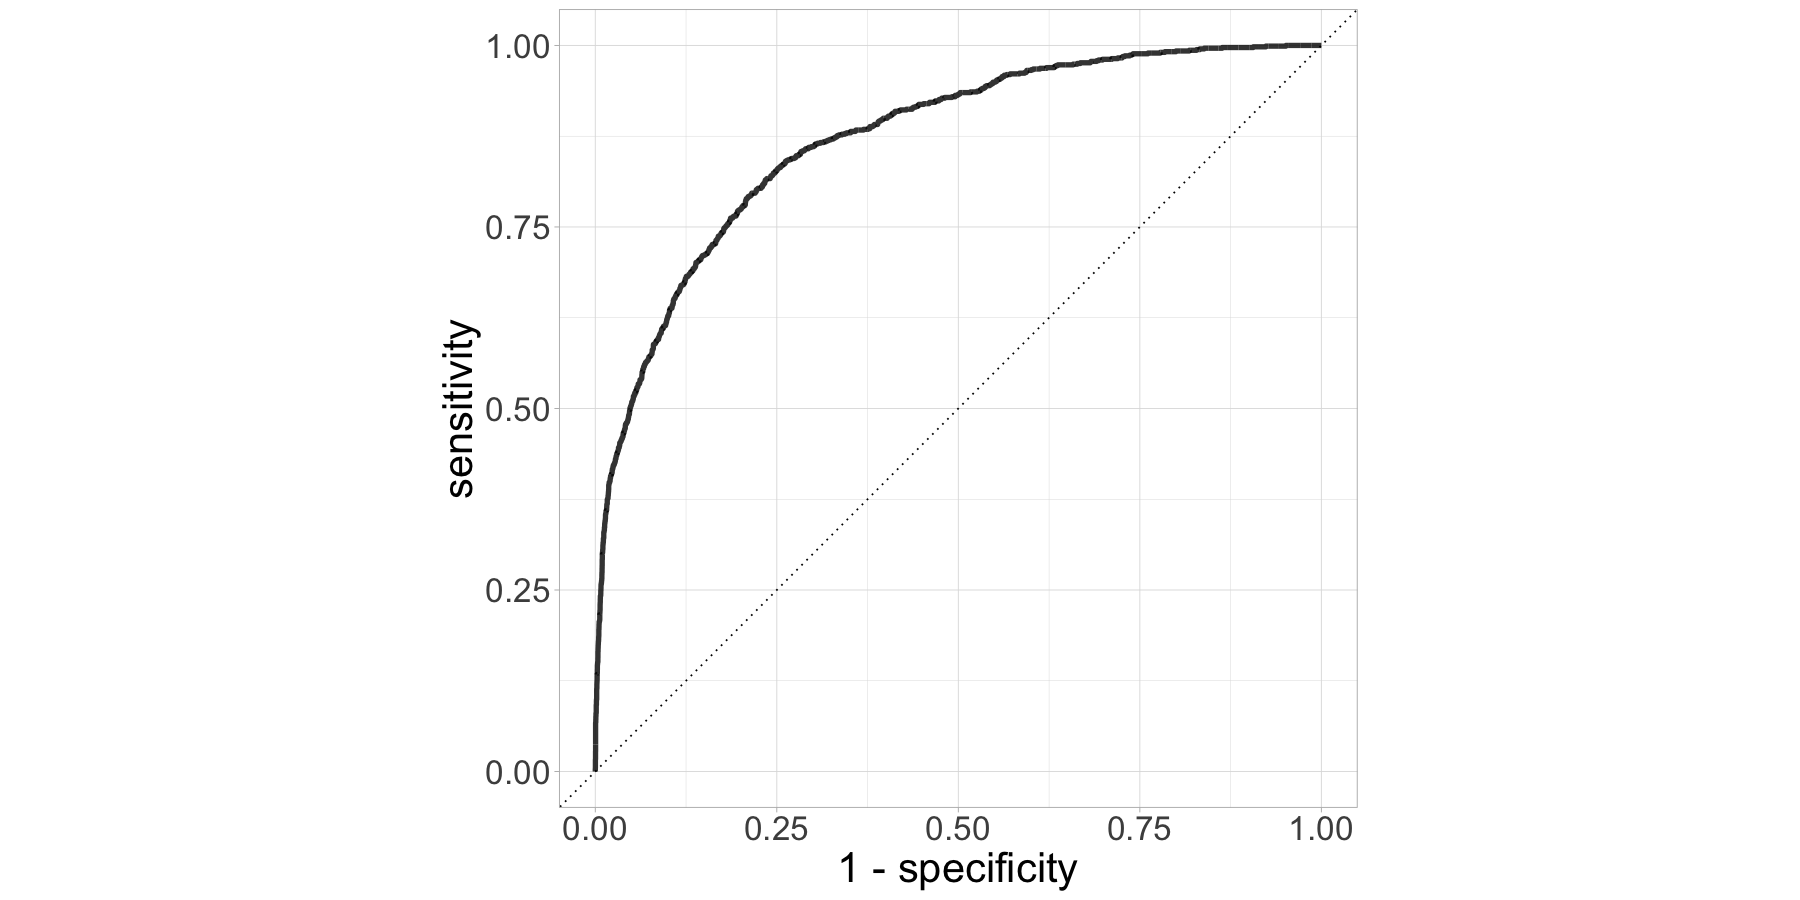

In [17]:
# Plot last ROC curve ####
last_lr_fit %>% 
  collect_predictions() %>% 
  roc_curve(children, .pred_children) %>% 
  ggplot(aes(x = 1 - specificity, y = sensitivity)) + 
  geom_path(lwd = 1.5, alpha = 0.8) +
  geom_abline(lty = 3) + 
  coord_equal()

In [18]:
# View metrics ####
last_lr_fit %>% 
  collect_metrics()

.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<chr>
accuracy,binary,0.93280000,Preprocessor1_Model1
roc_auc,binary,0.87103324,Preprocessor1_Model1
brier_class,binary,0.05516399,Preprocessor1_Model1


As we see, the out-of-sample AUC is very much in line with the in-sample one. Success!
This is now a model that we can use for prediction.

## Before you leave

Think back to the two approaches that we discussed at the beginning.
What are their problems (either overfitting or double dipping)?

**Provide your answers on Canvas.**